Import the necessary libraries and mount the drive onto Colab.

In [34]:
from PIL import Image
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
# from google.colab import drive
# drive.mount('/content/drive')

Switch to the directory containing the images zip file.

For me, it was here
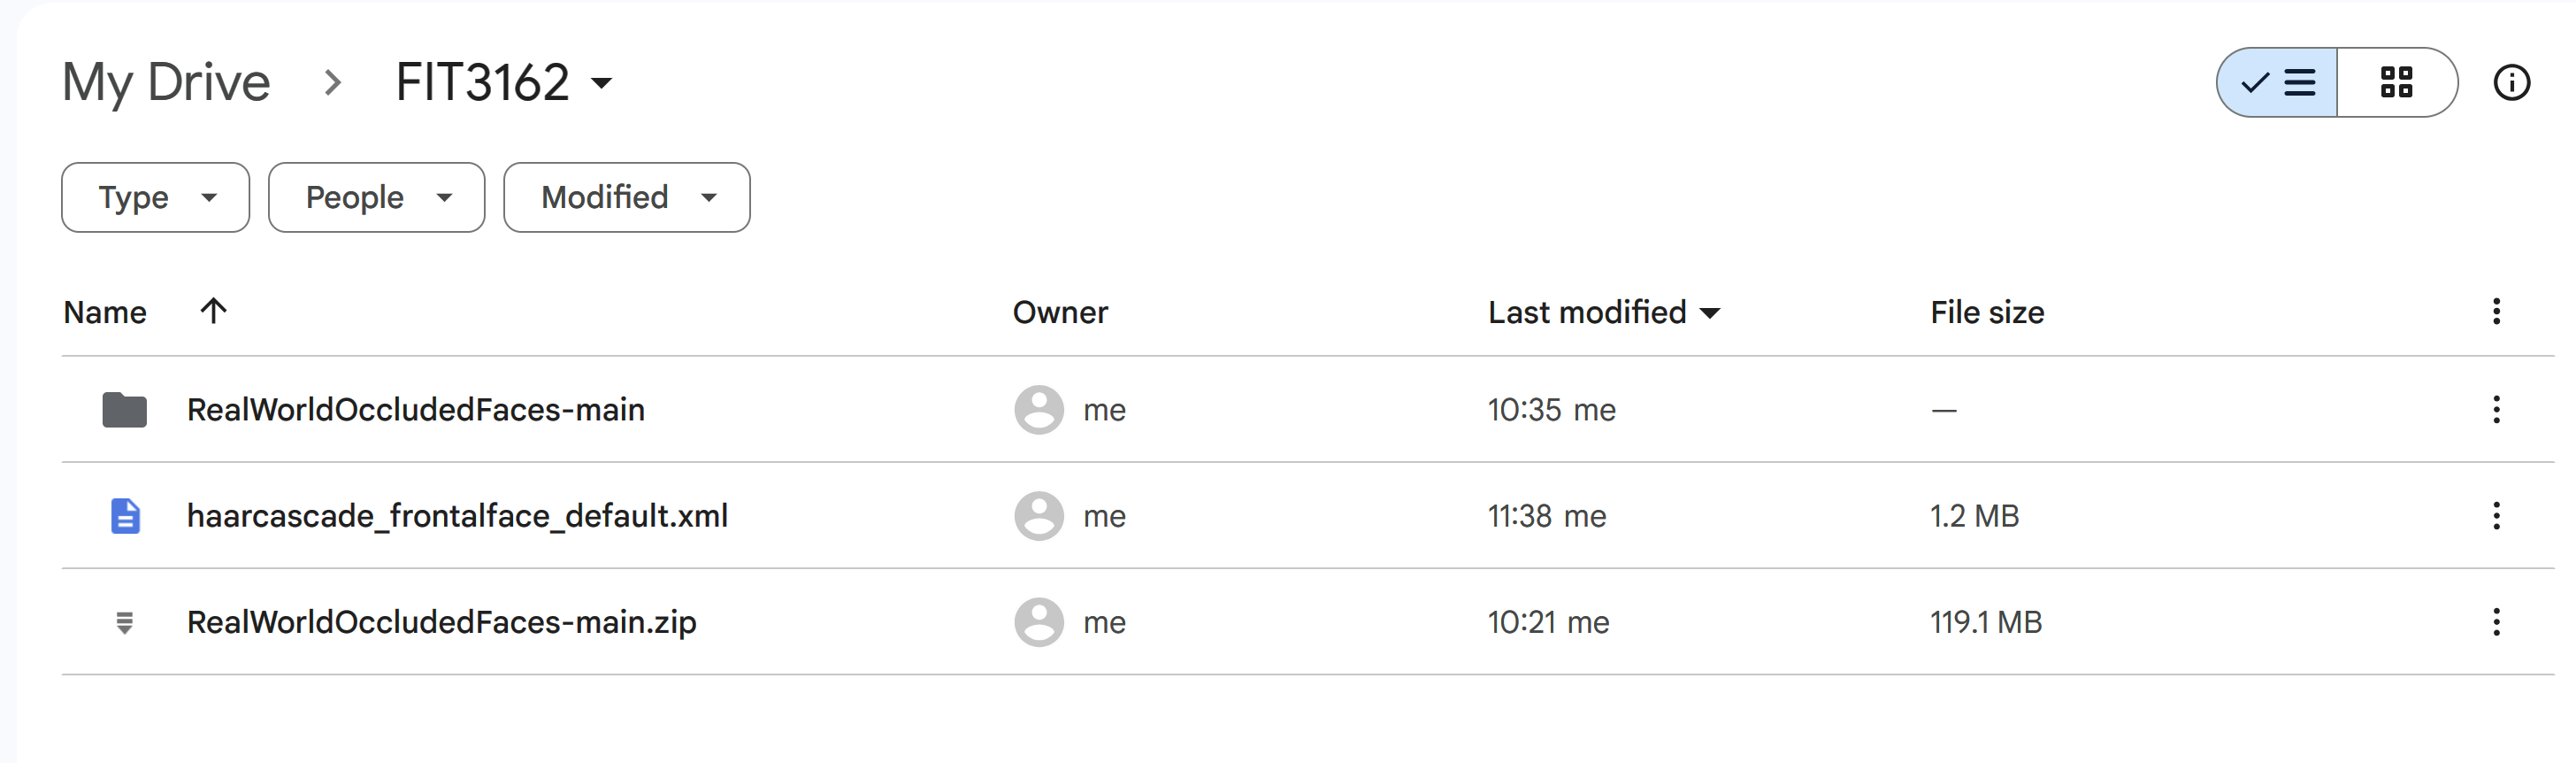

GUI location: My Drive/FIT3162/RealWorldOccludedFaces-main.zip

In [35]:
import os
# os.chdir('/content/drive/My Drive/FIT3162')

[RUN ONCE] Unzip and extract all files.

In [36]:
# Uncomment this code if you are running it for the first time.
# import zipfile
# path = 'RealWorldOccludedFaces-main.zip'
# zip_obj = zipfile.ZipFile(file=path, mode='r')
# zip_obj.extractall('./')
# zip_obj.close()

Here, we start with the neutral faces dataset.

In [37]:
print(f'A few samples of people in the dataset: {os.listdir("RealWorldOccludedFaces-main/images/neutral")[:5]}')
print(f'Number of unique ids: {len(os.listdir("RealWorldOccludedFaces-main/images/neutral"))}')

A few samples of people in the dataset: ['adrien_brody', 'alain_delon', 'alexander_zverev', 'al_pacino', 'amber_heard']
Number of unique ids: 182


[RUN ONCE] Shape of face images not the same. We rescale them to 64x64, and store them in a new directory.

In [38]:
# Uncomment this code if you are running it for the first time.

# def resize_neutral_images():
#   paths = [os.path.join('RealWorldOccludedFaces-main/images/neutral', f) for f in os.listdir('RealWorldOccludedFaces-main/images/neutral')]
#   # print(paths)

#   for name in os.listdir('RealWorldOccludedFaces-main/images/neutral'):
#     for img_name in os.listdir(f'RealWorldOccludedFaces-main/images/neutral/{name}'):
#       img_path = os.path.join(f'RealWorldOccludedFaces-main/images/neutral/{name}/', img_name)
#       image = Image.open(img_path).convert('L').resize((64,64))
#       image.save(os.path.join(f'RealWorldOccludedFaces-resized/images/neutral/{name}/', img_name))

#   return


# paths = [os.path.join('RealWorldOccludedFaces-resized/images/neutral', f) for f in os.listdir('RealWorldOccludedFaces-main/images/neutral')]
# for path in paths:
#   os.makedirs(f'{path}')
# resize_neutral_images()

Function to load the images into numpy arrays for model input.

In [39]:
def get_neutral_image_data():
  paths = [os.path.join('RealWorldOccludedFaces-resized/images/neutral', f) for f in os.listdir('RealWorldOccludedFaces-resized/images/neutral')]
  num_classes = len(os.listdir("RealWorldOccludedFaces-resized/images/neutral"))
  # print(paths)
  faces = []
  ids = []
  unique_id = 0

  for path in paths:
    # print(path)
    images = [os.path.join(path, f) for f in os.listdir(path)]
    for img in images:
      image = Image.open(img)
      #print(type(image))
      image_np = np.array(image, 'uint8')
      #print(type(image_np))
      id = [0] * num_classes
      id[unique_id] = 1
      ids.append(id)
      faces.append(image_np)
    unique_id += 1

  return np.array(ids), faces

In [40]:
ids, faces = get_neutral_image_data()  # might take a while, the dataset has ~6K images

In [41]:
print(f'Number of face images: {len(ids)}') # size of neutral faces dataset
print(f'Number of ids (must match above): {len(faces)}') #size of the array of face ids

Number of face images: 5927
Number of ids (must match above): 5927


In [42]:
ids
faces[0].shape


(64, 64)

Splitting the dataset into training and testing.

In [53]:
from sklearn.model_selection import train_test_split

# Assuming `X` is your feature data and `y` are your labels
# You should replace these with your actual data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(faces, ids, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [44]:
len(X_train) == int(0.8 * len(ids))

True

Defining a simple CNN (Generated by Microsoft Copilot)

In [45]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D

# # Shape of the input
# input_shape = (64, 64, 1)

# # Number of output classes
# num_classes = len(os.listdir("RealWorldOccludedFaces-resized/images/neutral"))

# # Define the model
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

From Gemini

In [46]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Shape of the input
# input_shape = (64, 64, 1)

# # Number of output classes
# num_classes = len(os.listdir("RealWorldOccludedFaces-resized/images/neutral"))

# model = Sequential([
#   Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # First Convolutional Layer with 32 filters
#   MaxPooling2D((2, 2)), # Pooling layer to reduce dimensionality
#   Conv2D(64, (3, 3), activation='relu'), # Second Convolutional Layer with 64 filters
#   MaxPooling2D((2, 2)),
#   Flatten(), # Flatten the output of the convolutional layers
#   Dense(128, activation='relu'), # First fully connected layer
#   Dense(num_classes, activation='softmax') # Output layer with 182 units and softmax activation
# ])

In [47]:
num_classes

182

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, activations

activation_func = "relu"

input_shape = (64, 64, 1)

model = Sequential()
model.add(layers.Conv2D(32, (3,3), padding='same', activation=activation_func, input_shape=input_shape))
model.add(layers.Conv2D(32, (3,3), padding='same', activation=activation_func))
model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation=activation_func))
model.add(layers.Conv2D(64, (3,3), padding='same', activation=activation_func))
model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Train the model

In [54]:
# Compile the model
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

model.fit(np.array(X_train), y_train, batch_size=32, epochs=20, verbose=1, validation_data=(np.array(X_valid), y_valid))

Epoch 1/20
134/134 [==============================] - 24s 178ms/step - loss: 0.0411 - accuracy: 0.9911 - val_loss: 0.1052 - val_accuracy: 0.9853
Epoch 2/20
134/134 [==============================] - 26s 194ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.0492 - val_accuracy: 0.9937
Epoch 3/20
134/134 [==============================] - 26s 193ms/step - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.0553 - val_accuracy: 0.9937
Epoch 4/20
134/134 [==============================] - 25s 183ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0550 - val_accuracy: 0.9937
Epoch 5/20
134/134 [==============================] - 24s 182ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 0.0579 - val_accuracy: 0.9937
Epoch 6/20
134/134 [==============================] - 25s 184ms/step - loss: 0.0101 - accuracy: 0.9977 - val_loss: 0.0620 - val_accuracy: 0.9937
Epoch 7/20
134/134 [==============================] - 25s 187ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0784 - val_ac

In [56]:
evaluation_results = model.evaluate(np.array(X_test), y_test)
metrics = ['loss', 'accuracy']
# Print the evaluation results
for metric, result in zip(metrics, evaluation_results):
    print(f'{metric}: {result}')

38/38 [==============================] - 2s 46ms/step - loss: 27.5043 - accuracy: 0.3145
loss: 27.504322052001953
accuracy: 0.3145025372505188
